**"Разработка модели классификации патологий по снимкам"**

Кузьмин Олег 2023.12.13 - 2023.12.20 (02-я неделя).

  



### Техническое задание

Техническое Задание для проекта стажировки
1. Введение
Цель проекта - создание продукта с использованием искусственного интеллекта для диагностики и лечения заболеваний ВНЧС, с использованием методов машинного обучения и нейронных сетей.
2. Задачи проекта
2.1. Обработка и анализ КЛКТ и МРТ снимков
- С использованием библиотеки Pydicom, провести загрузку и обработку КЛКТ и МРТ снимков в формате DICOM.
- Применив модели машинного обучения и базу TensorFlow и Keras для выявления патологий челюстных костей на основе анализа данных снимков.
2.2. Создание системы классификации и фреймворка предсказания
- Сформировать модель классификации патологий, основанную на архитектуре сверточных нейронных сетей с использованием Keras.
- Разработать механизм определения геометрии патологий с использованием анализа изображений OpenCV.
2.3. Разработка системы представления результатов
- Создание простого веб-интерфейса с помощью FastAPI или развертывание телеграм-бота для взаимодействия пользователя с системой и получения результатов анализа КЛКТ и МРТ снимков.
2.4. Интеграция разработанной системы в рабочий процесс клиники
- Интегрировать разработанное решение в привычный рабочий процесс клиники с использованием библиотек для обслуживания модели.
3. Методы разметки
 - labelImg, Roboflow, CVAT AI, Labelbox, VGG Image Annotator (VIA), COCO Annotator, Supervise.ly,
4. Время и среда работы
- Длительность проекта: 3 месяца.
- Среда разработки: Google Colaboratory
5. Заключение
Разработанный продукт должен обеспечивать эффективную аналитику снимков для диагностики заболеваний ВНЧС и формировать дальнейший план действий для изготовления последнего элайнера, используя взаимодействие ИИ и человеческого специалиста.

Ссылка на ТЗ от клиники:
https://docs.google.com/presentation/d/17oEmE4xG3jhlg64gDHrHICy1_i2XjoUn/edit?usp=sharing&ouid=104431004874051483278&rtpof=true&sd=true

## Загрузка приложений

In [ ]:
import numpy as np # Подключаем библиотеку numpy
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist                                     # pагрузка базы ч/б картинок размером 28х28 пикселей с названием Mnist/KERAS
from tensorflow.keras.datasets import mnist, fashion_mnist                      # загружаем готовые базы mnist

from tensorflow.keras import utils                                              # eтилиты для to_categorical
from sklearn.model_selection import train_test_split                            # модуль разбивки выборки на тренировочную/тестовую
from sklearn.preprocessing import StandardScaler                                # модуль стандартизации данных

from tensorflow.keras.models import Model, Sequential                           # подлючаем модуль создания модели НС Sequential и Modsl
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
                                                                                # подключаем модуль создания полносвязных слоев Dense
from tensorflow.keras.optimizers import Adam                                    # подключаем оптимизатор Adam

from tensorflow.keras.preprocessing import image                                # для отрисовки изображения
import pylab                                                                    # модуль построения графиков
from mpl_toolkits.mplot3d import Axes3D                                         # модуль трехмерной графики
import matplotlib.pyplot as plt                                                 # отрисовка изображений
from PIL import Image                                                           # отрисовка изображений
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
                                                                                # отрисовывать изображения в ноутбуке, а не в консоль или файk

import os
from google.colab import files                                                  # для загрузки своей картинки
from tensorflow.keras import backend as K                                       # подтягиваем базовые керасовские функции
from tensorflow.keras.callbacks import LambdaCallback
from google.colab import drive                                                  # модуль для работы с google диском
import time, random
import zipfile                      # Для начала нам нужно импортировать модуль zipfile:

## Определимся с терминами и понятиями в имеющейся у Заказчика базе знаний

In [ ]:
# В список собраны сокращенные названия диагнозов после анализа снимков с размерами
PR_list = ['PR1_norm', 'PR1_later', 'PR1_medial',
           'PR2_norm', 'PR2_kompres','PR2_distrak', 'PR2_dictal', 'PR2_mezial',
           'PR3_norm', 'PR3_kompres', 'PR3_distrak', 'PR3_later', 'PR3_medial']
print('Колонка сокращенных диагнозов после анализа снимков. Разместить в карте пациента')
PR_list

Колонка сокращенных диагнозов после анализа снимков. Разместить в карте пациента


['PR1_norm',
 'PR1_later',
 'PR1_medial',
 'PR2_norm',
 'PR2_kompres',
 'PR2_distrak',
 'PR2_dictal',
 'PR2_mezial',
 'PR3_norm',
 'PR3_kompres',
 'PR3_distrak',
 'PR3_later',
 'PR3_medial']

In [ ]:
# словарь сокращенных и полных названий диагнозов. Для трех разных проекций
PR_dist = {'PR1_norm':'Центральное положение суставной головки Нормально',
          'PR1_later':'Латеральное положение суставной головки ',
          'PR1_medial':'Медиальное положение суставной головки',

          'PR2_norm':'Центральное положение суставной головки Нормально',
          'PR2_kompres':'Компрессия. Сужение суставной щели',
          'PR2_distrak':'Дистракция. Расширение суставной щели',
          'PR2_dictal':'Дистальное положение суставной головки',
          'PR2_mezial': 'Мезиальное положение суставной головки',

          'PR3_norm':'Центральное положение суставной головки Нормально',
          'PR3_kompres': 'Компрессия. Сужение суставной щели',
          'PR3_distrak':'Дистракция. Расширение суставной щели ',
          'PR3_later':'Лотеральное положение суставной головки',
          'PR3_medial':'Медиальное положение суставной головки'}
print('Список ключей словаря', '\n', PR_dist.keys())

Список ключей словаря 
 dict_keys(['PR1_norm', 'PR1_later', 'PR1_medial', 'PR2_norm', 'PR2_kompres', 'PR2_distrak', 'PR2_dictal', 'PR2_mezial', 'PR3_norm', 'PR3_kompres', 'PR3_distrak', 'PR3_later', 'PR3_medial'])


In [ ]:
# Список обозначений мест измерений на снимках
LaPa = ['pr_diag','l<', 'l>', 'l^', 'lv', 'p<', 'p>', 'p^', 'pv']
LaPa

['pr_diag', 'l<', 'l>', 'l^', 'lv', 'p<', 'p>', 'p^', 'pv']

In [ ]:
#  Список проекций в которых производится съемка
Proekc = ['PR1 Аксиальная проекция','PR2 Сагитальная проекция','PR3 Корональная проекция']
print('Горизонтальная проекция      ', Proekc[0])
print('Вертикальная проекция, слева ', Proekc[1])
print('Вертикальная проекция, справа', Proekc[2])

Горизонтальная проекция       PR1 Аксиальная проекция
Вертикальная проекция, слева  PR2 Сагитальная проекция
Вертикальная проекция, справа PR3 Корональная проекция


In [ ]:
interval = [9,17,25,33,41,49,57,65,73,81,89,97,105]

Создадим пустую форму карты пациента для записи в нее из общего DS информации


In [ ]:
column = ['pr_diag','PR1_norm_La<',  'PR1_norm_La>', 'PR1_norm_La^', 'PR1_norm_Lav', 'PR1_norm_Pa<', 'PR1_norm_Pa>', 'PR1_norm_Pa^', 'PR1_norm_Pav']
df_karta0 =pd.DataFrame(index=[0,1,2,3,4,5,6,7,8,9,10,11,12,13], columns= LaPa) #column)
df_karta0.shape
df_karta0

,pr_diag,l<,l>,l^,lv,p<,p>,p^,pv
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Локальные функции

Функция занесения индивидуальных данных из DF в учетную карточку с результатами исследований

In [ ]:
# Код формирование карты пациента из открытого на предыдущем этапе df_com
# полученные данные в виде строки в более удобочитаемую карточку

def gen_karta (str_pacienta, ID ):  #(df_karta0, interval, PR_list, str_pacienta ):
  a = 1
  b = 0
  PR = 0
  karta_P = df_karta0.copy()

  for ca in PR_list:      # PR1_norm  цикл движения по столбцу сокращенных диагнозов в карке пациента

    karta_P.iloc[PR,0] = ca
    B = interval[b]
    #print('B',B)
    s = str_pacienta.iloc[0,a:B]
    ss = list(s)
    #print(ss)
    karta_P.iloc[PR,1:9] = ss
    a = B
    b += 1
    PR += 1
  karta_P.iloc[13,0] = 'ID пациента'
  karta_P.iloc[13,1] = ID
    #print(ca, 'обработан')
  return karta_P

## PR1 Аксиальная проекция

### Центральное положение суставной головки. Норма

In [ ]:
zip_file = '/content/drive/MyDrive/BD/PR1_norm.zip'             # путь к архиву
norm = zipfile.ZipFile(zip_file, 'r')                           # откроем ZIP-архив с помощью функции ZipFile и сохранить его в переменную:
norm.extractall('/content/drive/MyDrive/BD/PR1_norm/')          # достаем все файлы из архива и пишем в папку PR1_norm
norm_list = os.listdir('/content/drive/MyDrive/BD/PR1_norm')    # составим список всех файлов в папке PR1_norm
print('Кол-во файлов в папке', len(norm_list))
#norm_list


Кол-во файлов в папке 224


In [ ]:
norm_list[97:116]

['è99ïá.jpg',
 'è100ïá.jpg',
 'è100Åá.jpg',
 'è101ïá.jpg',
 'è102ïá.jpg',
 'è103ïá.jpg',
 'è104Åá.jpg',
 'è105Åá.jpg',
 'è106ïá.jpg',
 'è106Åá.jpg',
 'è107ïá.jpg',
 'è107Åá.jpg',
 'è108ïá.jpg',
 'è108Åá.jpg',
 'è109ïá.jpg',
 'è109Åá.jpg',
 'è110ïá.jpg',
 'è110Åá.jpg',
 'è111ïá.jpg']

### Латеральное положение суставной головки

In [ ]:
zip_file = '/content/drive/MyDrive/BD/PR1_later.zip'             # путь к архиву
later = zipfile.ZipFile(zip_file, 'r')                           # откроем ZIP-архив с помощью функции ZipFile и сохранить его в переменную:
later.extractall('/content/drive/MyDrive/BD/PR1_later/')          # достаем все файлы из архива и пишем в папку PR1_later
later_list = os.listdir('/content/drive/MyDrive/BD/PR1_later')    # составим список всех файлов в папке PR1_later
print('Кол-во файлов в папке', len(later_list))
#later_list


Кол-во файлов в папке 225


In [ ]:
later_list[76:81]

['è99Åá.jpg',
 'è101Åá.jpg',
 'è104ïá.jpg',
 'è105ïá.jpg',
 'è113ïá.jpg']

### Медиальное положение суставной головки

In [ ]:
zip_file = '/content/drive/MyDrive/BD/PR1_media.zip'             # путь к архиву
media = zipfile.ZipFile(zip_file, 'r')                           # откроем ZIP-архив с помощью функции ZipFile и сохранить его в переменную:
media.extractall('/content/drive/MyDrive/BD/PR1_media/')          # достаем все файлы из архива и пишем в папку PR1_media
media_list = os.listdir('/content/drive/MyDrive/BD/PR1_media')    # составим список всех файлов в папке PR1_media
print('Кол-во файлов в папке', len(media_list))
#media_list


Кол-во файлов в папке 54


In [ ]:
media_list[30:34]

['è92ïá.jpg', 'è102Åá.jpg', 'è103Åá.jpg', 'è116ïá.jpg']

## PR2 Сагитальная проекция

### Центральное положение суставной головки. Норма

In [ ]:
zip_file = '/content/drive/MyDrive/BD/PR2_norm.zip'             # путь к архиву
norm = zipfile.ZipFile(zip_file, 'r')                           # откроем ZIP-архив с помощью функции ZipFile и сохранить его в переменную:
norm.extractall('/content/drive/MyDrive/BD/PR2_norm/')          # достаем все файлы из архива и пишем в папку PR1_norm
norm_list = os.listdir('/content/drive/MyDrive/BD/PR2_norm')    # составим список всех файлов в папке PR1_norm
print('Кол-во файлов в папке /BD/PR2_norm/', len(norm_list))
#norm_list


Кол-во файлов в папке /BD/PR2_norm/ 69


In [ ]:
norm_list[30:35]

['è99ïß.jpg', 'è104ïß.jpg', 'è104Åß.jpg', 'è110ïß.jpg', 'è111ïß.jpg']

### Компрессия. Сужение суставной щели

In [ ]:
zip_file = '/content/drive/MyDrive/BD/PR2_kompres.zip'                # путь к архиву
kompres = zipfile.ZipFile(zip_file, 'r')                              # откроем ZIP-архив с помощью функции ZipFile и сохранить его в переменную:
kompres.extractall('/content/drive/MyDrive/BD/PR2_kompres/')          # достаем все файлы из архива и пишем в папку PR1_kompres
kompres_list = os.listdir('/content/drive/MyDrive/BD/PR2_kompres')    # составим список всех файлов в папке PR2_kompres
print('Кол-во файлов в папке', len(kompres_list))
#kompres_list


Кол-во файлов в папке 231


In [ ]:
kompres_list[92:106]

['è99Åß.jpg',
 'è100ïß.jpg',
 'è100Åß.jpg',
 'è101Åß.jpg',
 'è102ïß.jpg',
 'è102Åß.jpg',
 'è103ïß.jpg',
 'è103Åß.jpg',
 'è108ïß.jpg',
 'è108Åß.jpg',
 'è109ïß.jpg',
 'è109Åß.jpg',
 'è110Åß.jpg',
 'è112ïß.jpg']

### Дистракция. Расширение суставной щели

In [ ]:
#zip_file = '/content/drive/MyDrive/BD/PR2_distrak.zip'             # путь к архиву
#distrak = zipfile.ZipFile(zip_file, 'r')                           # откроем ZIP-архив с помощью функции ZipFile и сохранить его в переменную:
#distrak.extractall('/content/drive/MyDrive/BD/PR2_distrak/')          # достаем все файлы из архива и пишем в папку PR1_distrak
distrak_list = os.listdir('/content/drive/MyDrive/BD/PR2_distrak')    # составим список всех файлов в папке PR2_distrak
print('Кол-во файлов в папке', len(distrak_list))
#distrak_list


Кол-во файлов в папке 67


In [ ]:
print('Нет пациентов с номерами от 100 до 110')

Нет пациентов с номерами от 100 до 110


### Дистальное положение суставной головки.

In [ ]:
zip_file = '/content/drive/MyDrive/BD/PR2_dictal.zip'                # путь к архиву
dictal = zipfile.ZipFile(zip_file, 'r')                              # откроем ZIP-архив с помощью функции ZipFile и сохранить его в переменную:
dictal.extractall('/content/drive/MyDrive/BD/PR2_dictal/')          # достаем все файлы из архива и пишем в папку PR1_dictal
dictal_list = os.listdir('/content/drive/MyDrive/BD/PR2_dictal')    # составим список всех файлов в папке PR2_dictal
print('Кол-во файлов в папке', len(dictal_list))
#dictal_list


Кол-во файлов в папке 199


In [ ]:
dictal_list[60:70]

['è95Åß.jpg',
 'è101ïß.jpg',
 'è101Åß.jpg',
 'è103ïß.jpg',
 'è103Åß.jpg',
 'è105ïß.jpg',
 'è105Åß.jpg',
 'è106ïß.jpg',
 'è106Åß.jpg',
 'è116ïß.jpg']

### Мезиальное положение суставной головки.

In [ ]:
zip_file = '/content/drive/MyDrive/BD/PR2_mezial.zip'                # путь к архиву
mezial = zipfile.ZipFile(zip_file, 'r')                              # откроем ZIP-архив с помощью функции ZipFile и сохранить его в переменную:
mezial.extractall('/content/drive/MyDrive/BD/PR2_mezial/')          # достаем все файлы из архива и пишем в папку PR1_mezial
mezial_list = os.listdir('/content/drive/MyDrive/BD/PR2_mezial')    # составим список всех файлов в папке PR2_mezial
print('Кол-во файлов в папке', len(mezial_list))
#mezial_list


Кол-во файлов в папке 102


In [ ]:
mezial_list[41:45]

['è97Åß.jpg', 'è107ïß.jpg', 'è107Åß.jpg', 'è115ïß.jpg']

## PR3 Корональная проекция

### Центральное положение суставной головки. Норма

In [ ]:
zip_file = '/content/drive/MyDrive/BD/PR3_norm.zip'             # путь к архиву
norm = zipfile.ZipFile(zip_file, 'r')                           # откроем ZIP-архив с помощью функции ZipFile и сохранить его в переменную:
norm.extractall('/content/drive/MyDrive/BD/PR3_norm/')          # достаем все файлы из архива и пишем в папку PR3_norm
norm_list = os.listdir('/content/drive/MyDrive/BD/PR3_norm')    # составим список всех файлов в папке PR3_norm
print('Кол-во файлов в папке /BD/PR3_norm/', len(norm_list))
#norm_list


Кол-во файлов в папке /BD/PR3_norm/ 161


In [ ]:
norm_list[67:80]

['è99Å¬.jpg',
 'è100ï¬.jpg',
 'è102ï¬.jpg',
 'è102Å¬.jpg',
 'è103ï¬.jpg',
 'è103Å¬.jpg',
 'è104Å¬.jpg',
 'è106ï¬.jpg',
 'è107ï¬.jpg',
 'è107Å¬.jpg',
 'è109ï¬.jpg',
 'è110ï¬.jpg',
 'è111ï¬.jpg']

### Компрессия. Сужение суставной щели

In [ ]:
zip_file = '/content/drive/MyDrive/BD/PR3_kompres.zip'                # путь к архиву
kompres = zipfile.ZipFile(zip_file, 'r')                              # откроем ZIP-архив с помощью функции ZipFile и сохранить его в переменную:
kompres.extractall('/content/drive/MyDrive/BD/PR3_kompres/')          # достаем все файлы из архива и пишем в папку PR3_kompres
kompres_list = os.listdir('/content/drive/MyDrive/BD/PR3_kompres')    # составим список всех файлов в папке PR3_kompres
print('Кол-во файлов в папке', len(kompres_list))
#kompres_list


Кол-во файлов в папке 132


In [ ]:
kompres_list[44:52]

['è95Å¬.jpg',
 'è100Å¬.jpg',
 'è104ï¬.jpg',
 'è108ï¬.jpg',
 'è108Å¬.jpg',
 'è109Å¬.jpg',
 'è110Å¬.jpg',
 'è114Å¬.jpg']

### Дистракция. Расширение суставной щели

In [ ]:
zip_file = '/content/drive/MyDrive/BD/PR3_distrak.zip'             # путь к архиву
distrak = zipfile.ZipFile(zip_file, 'r')                           # откроем ZIP-архив с помощью функции ZipFile и сохранить его в переменную:
distrak.extractall('/content/drive/MyDrive/BD/PR3_distrak/')          # достаем все файлы из архива и пишем в папку PR3_distrak
distrak_list = os.listdir('/content/drive/MyDrive/BD/PR3_distrak')    # составим список всех файлов в папке PR3_distrak
print('Кол-во файлов в папке', len(distrak_list))
#distrak_list


Кол-во файлов в папке 46


In [ ]:
print('Нет пациентов с номерами от 100 до 110')

Нет пациентов с номерами от 100 до 110


### Латеральное положение суставной головки.

In [ ]:
zip_file = '/content/drive/MyDrive/BD/PR3_later.zip'                # путь к архиву
later = zipfile.ZipFile(zip_file, 'r')                              # откроем ZIP-архив с помощью функции ZipFile и сохранить его в переменную:
later.extractall('/content/drive/MyDrive/BD/PR3_later/')          # достаем все файлы из архива и пишем в папку PR3_later
later_list = os.listdir('/content/drive/MyDrive/BD/PR3_later')    # составим список всех файлов в папке PR3_later
print('Кол-во файлов в папке', len(later_list))
#later_list


Кол-во файлов в папке 205


In [ ]:
later_list[102:107]

['è97Å¬.jpg', 'è101ï¬.jpg', 'è105ï¬.jpg', 'è105Å¬.jpg', 'è115ï¬.jpg']

### Мезиальное положение суставной головки.

In [ ]:
zip_file = '/content/drive/MyDrive/BD/PR3_medial.zip'                # путь к архиву
medial = zipfile.ZipFile(zip_file, 'r')                              # откроем ZIP-архив с помощью функции ZipFile и сохранить его в переменную:
medial.extractall('/content/drive/MyDrive/BD/PR3_medial/')          # достаем все файлы из архива и пишем в папку PR3_medial
medial_list = os.listdir('/content/drive/MyDrive/BD/PR3_medial')    # составим список всех файлов в папке PR3_medial
print('Кол-во файлов в папке', len(medial_list))
#medial_list


Кол-во файлов в папке 25


In [ ]:
medial_list[4:7]

['è60Å¬.jpg', 'è106Å¬.jpg', 'è117Å¬.jpg']

## Загрузка снимков jpg

Код из словаря операторов

In [ ]:
#zip_file = '/content/drive/MyDrive/Colab Notebooks/ДЗ 16 Автокодировщики /facez.zip'             # путь к архиву
#norm = zipfile.ZipFile(zip_file, 'r')                        # откроем ZIP-архив с помощью функции ZipFile и сохранить его в переменную:
#norm.extractall('/content/drive/MyDrive/BD/--------/')       # достаем все файлы из архива и пишем в папку Facez

images_dir = '/content/drive/MyDrive/BD/PR1_norm'             # зададим имя папки в которую распоковали изображения
norm_list = os.listdir('/content/drive/MyDrive/BD/PR1_norm')  # составим список всех файлов в папке PR1_norm
print('Кол-во файлов в папке', len(norm_list))
#norm_list



Кол-во файлов в папке 224


In [ ]:
print('Смотрим название файла из списка', norm_list[211])
print('Переводим файл из jpg формата в np массив')
pch = os.path.join(images_dir, norm_list[211])                       # Соберем полный путь к очередному файлу
wq = image.load_img('/content/drive/MyDrive/BD/PR1_norm/è240Åá.jpg') # Загружаем изображение с помощью image.load_img()
wq_np = image.img_to_array(wq)                                       # переводим изображение в numpy массив
print('Тип переменной', type(wq_np))
print('Размер np-изображения',wq_np.shape)

Смотрим название файла из списка è240Åá.jpg
Переводим файл из jpg формата в np массив
Тип переменной <class 'numpy.ndarray'>
Размер np-изображения (603, 976, 3)


In [ ]:
img_height = 603                                              # зададим высоту изображений
img_width = 976                                               # зададим ширину избражений

def load_images(norm_list, img_height, img_width):
  ''' Функция загрузки изображений
      Вход: передаем список распакованых в папку Facez файлов из zip архива
      высоту и ширину картинки к которой будут преобразованы загружаемые изображения
  '''
  list_images = []                                           # создаем пустой список в который будем загружать изображения
  for img in norm_list:                                      # цикл по списку распакованных файлов
    pch = os.path.join(images_dir, img)                      # соберем полный путь к очередному файлу

    wq = image.load_img(pch, target_size=(img_height, img_width), color_mode='grayscale') # Загружаем изображение с помощью image.load_img(), конвертируя его в нужный формат
                                                                                          # подаем на вход: 1. путь к файлу 2. размер получаемой картинки. 3.цветовую гамму
    list_images.append(image.img_to_array(wq)/255)           # нормируем изображение в диапазон от 0 до 1 и записываем в список
    norm_np =  np.array(list_images)                         # переводим список изображений в numpy массив

  return norm_np                                             # возвращаем numpy массив загруженных избражений

Переведем все файлы из списка в np массив

In [ ]:
cur_time = time.time()
xTrain_imag = load_images(norm_list, img_height, img_width)  # загрузим избражения лиц с задаными размерами картинки
print ('Время загрузки: ', round(time.time()-cur_time, 2), 'с', sep='')
print('Размерность массива', xTrain_imag.shape)              # выведем размерность массива

Время загрузки: 30.47с
Размерность массива (224, 603, 976, 1)


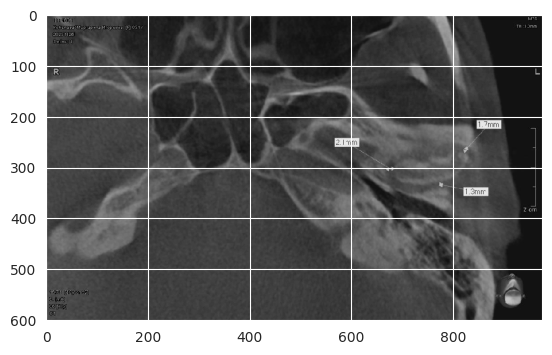

In [ ]:
plt.imshow(xTrain_imag[np.random.randint(0, xTrain_imag.shape[0])].reshape(img_height,img_width), cmap='gray') # выведем случайное изображение
plt.show()

# Работа с табличными данными


## таблица пациентов


In [ ]:
# Укажим путь к файлу с данными на моем диске
way = '/content/drive/MyDrive/Стажировка 3/Пациенты.xlsx'
df_pac = pd.read_excel(way)  # Чтение данных из файла excel в pandas.DataFrame
pac_list = df_pac.columns.to_list()
print(pac_list)
print(df_pac.shape)
df_pac[99:111]

['ID', 'Пациенты', 'Доктор']
(310, 3)


,ID,Пациенты,Доктор
99,Nw100,Кобелева М.И.,Алина
100,Nw101,Смирнов Б.С. 23.01.2023,Инга
101,Nw102,Созыкина Е.С. 02.04.2023,Инга
102,Nw103,Созыкина Е.С. 15.09.2023,Инга
103,Nw104,Соколов Э.С.,Инга
104,Nw105,Бобрышева Л.В.,Кристина
105,Nw106,Богданов Р.С. 22.12.2022,Кристина
106,Nw107,Кобцев А.А.,Алина
107,Nw108,Ковнацкий С.А. 15.10.2023,Алина
108,Nw109,Ковнацкий С.А. 24.08.2023,Алина


In [ ]:
pac_list

['ID', 'Пациенты', 'Доктор']

In [ ]:
ka = 'Nw100'
a = df_pac.loc[df_pac.ID == ka, 'Пациенты']
b = df_pac.loc[df_pac.ID == ka, 'Доктор']
#print('a', a)
#print(a[99])
print('Пациент', a.iloc[0])
print('Доктор ', b.iloc[0])

Пациент Кобелева М.И.
Доктор  Алина 


## izmerenia для NB

In [ ]:
# Укажим путь к файлу с данными на моем диске
way = '/content/drive/MyDrive/Стажировка 3/izmerenia для NB.xlsx'
df_com = pd.read_excel(way)  # Чтение данных из файла excel в pandas.DataFrame
print(df_com.shape)
df_com

(45, 105)


,ID,PR1_norm_La<,PR1_norm_La>,PR1_norm_La^,PR1_norm_Lav,PR1_norm_Pa<,PR1_norm_Pa>,PR1_norm_Pa^,PR1_norm_Pav,PR1_later_La<,...,PR3_later_Pk^,PR3_later_Pkv,PR3_medial_Lk<,PR3_medial_Lk>,PR3_medial_Lk^,PR3_medial_Lkv,PR3_medial_Pk<,PR3_medial_Pk>,PR3_medial_Pk^,PR3_medial_Pkv
0,Nw100,4.50,1.90,3.1,1.5,2.10,4.50,4.0,1.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Nw101,3.10,2.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Nw102,1.40,1.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Nw103,1.60,2.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Nw104,NaN,NaN,NaN,NaN,1.20,2.30,NaN,NaN,5.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Nw105,NaN,NaN,NaN,NaN,2.90,3.30,NaN,NaN,3.90,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Nw106,2.70,1.80,NaN,NaN,3.30,3.10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.9,1.9,2.4,NaN
7,Nw107,3.00,1.70,1.0,2.4,NaN,4.60,3.9,4.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Nw108,1.50,1.80,NaN,2.1,1.20,1.00,NaN,2.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Nw109,2.80,1.50,2.4,2.7,1.60,1.00,NaN,2.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_list = df_com.columns.to_list()
print('Название первого(0) столбца', df_list[0])
print('Группа столбцов Аксиальной проекции показатели norm')
df_list[1:9]

Название первого(0) столбца ID
Группа столбцов Аксиальной проекции показатели norm


['PR1_norm_La<',
 'PR1_norm_La>',
 'PR1_norm_La^',
 'PR1_norm_Lav',
 'PR1_norm_Pa<',
 'PR1_norm_Pa>',
 'PR1_norm_Pa^',
 'PR1_norm_Pav']

## Формирование карты пациента по результатам анализов из df_com


Список всех ID пациентов в DF

In [ ]:
#id_list = df_com['ID'].unique()
id_list = df_com.ID.unique()
print('Кол-во пациентов в DS', len(id_list))
id_list[:]

Кол-во пациентов в DS 45


array(['Nw100', 'Nw101', 'Nw102', 'Nw103', 'Nw104', 'Nw105', 'Nw106',
       'Nw107', 'Nw108', 'Nw109', 'Nw110', 'Nw111', 'Nw112', 'Nw113',
       'Nw114', 'Nw115', 'Nw116', 'Nw117', 'Nw118', 'Nw119', 'Nw120',
       'Nw121', 'Nw122', 'Nw123', 'Nw124', 'Nw125', 'Nw126', 'Nw127',
       'Nw128', 'Nw129', 'Nw130', 'Nw131', 'Nw132', 'Nw133', 'Nw134',
       'Nw135', 'Nw136', 'Nw137', 'Nw138', 'Nw139', 'Nw140', 'Nw141',
       'Nw142', 'Nw143', 'Nw144'], dtype=object)

К данным пациента можем обратиться с помощью его порядкового номера в списке

In [ ]:
# Допустим, мы хотим найти n-го пациента из списка
n = int(input('Введите порядковый номер пациента из списка:'))
mask = df_com['ID'] == id_list [n]  # номер пациента в списке
ID = id_list [n]                                                               # строка с ID пациента присваиваем переменной
# df_com[mask]
str_pacienta = df_com[mask]                                                    # достаем из df_com строку с измерениями указанного пациента
#print('И строку с его замерами:')
#str_pacienta
df_karta = gen_karta (str_pacienta, ID )                                       # сформированную строку передаем в функцию генерации карты пациента
df_karta

rem_mns = df_karta.dropna(axis=0, how='all', subset=k_list[1:])
                                      #  axis = 0 - удаляем построчно,
                                      #  axis = 1 выкидываем столбец;
                                      #  how ='any' - выкидываем, если есть хотя бы одна ячейка пустая.
                                      #  how = 'all' - выкидываем, если есть полностью пустая строка или столбец

rem_mns

Введите порядковый номер пациента из списка:1


,pr_diag,l<,l>,l^,lv,p<,p>,p^,pv
0,PR1_norm,3.1,2.1,NaN,NaN,NaN,NaN,NaN,NaN
1,PR1_later,NaN,NaN,NaN,NaN,1.5,3.7,NaN,NaN
4,PR2_kompres,NaN,NaN,NaN,NaN,2.3,1.5,2.4,NaN
6,PR2_dictal,2.3,1.9,4.0,NaN,2.3,1.5,2.4,NaN
11,PR3_later,1.7,1.8,2.9,NaN,1.2,3.1,1.4,NaN
13,ID пациента,Nw101,NaN,NaN,NaN,NaN,NaN,NaN,NaN


К данным пациента можем обратиться с помощью строки с написанием его ID

In [ ]:
pacient = 'Nw103'                  # создадим переменную с ID номером пациента
mask = df_com['ID'] == pacient     # смотрим пациента по ID
df_com[mask]


К данным пациента можем обратиться с помощью строки с его ФИО

In [ ]:
fio = 'Кобелева М.И.'                               # создадим переменную с ID номером пациента
a = df_pac.loc[df_pac.Пациенты == fio, 'ID']        # найдем ФИО в df_pac в столбце Пациенты
ID = a.iloc[0]
print('Возвращаем ID пациента:', a.iloc[0])         #
mask = df_com['ID'] == a.iloc[0]                    # создадим маску, подав переменную а (с ID-fio) в df_com
str_pacienta = df_com[mask]                         # достаем из df_com строку с измерениями указанного пациента
#print('И строку с его замерами:')
#str_pacienta
df_karta = gen_karta (str_pacienta, ID )                           # сформированную строку передаем в функцию генерации карты пациента
#df_karta

Возвращаем ID пациента: Nw100


## karta ID   загрузка карты из внешнего источника

In [ ]:
# Укажим путь к файлу с данными на моем диске
way = '/content/drive/MyDrive/Стажировка 3/Karta_ID.xlsx'
df_karta = pd.read_excel(way)  # Чтение данных из файла excel в pandas.DataFrame
print(df_karta.shape)
p_list = df_karta['proekc'].unique()
print('p_list',p_list)
k_list = df_karta.columns.to_list()
df_karta

(13, 11)
p_list ['PR1_norm' 'PR1_later' 'PR1_medial' 'PR2_norm' 'PR2_kompres'
 'PR2_distrak' 'PR2_dictal' 'PR2_mezial' 'PR3_norm' 'PR3_kompres'
 'PR3_distrak' 'PR3_later' 'PR3_medial']


,ID,proekc,l/p,l<,l>,l^,lv,p<,p>,p^,pv
0,КА100,PR1_norm,La/Pa,4.5,1.9,3.1,1.5,2.1,4.5,4.0,1.8
1,КА100,PR1_later,La/Pa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,КА100,PR1_medial,La/Pa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,КА100,PR2_norm,Lc/Pc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,КА100,PR2_kompres,Lc/Pc,2.3,1.9,2.2,NaN,1.8,1.9,1.9,NaN
5,КА100,PR2_distrak,Lc/Pc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,КА100,PR2_dictal,Lc/Pc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,КА100,PR2_mezial,Lc/Pc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,КА100,PR3_norm,Lk/Pk,2.0,1.1,1.8,NaN,NaN,NaN,NaN,NaN
9,КА100,PR3_kompres,Lk/Pk,NaN,NaN,NaN,NaN,1.0,3.0,2.0,NaN


In [ ]:
p_list = df_karta['pr_diag'].unique()
#print('p_list',p_list)
k_list = df_karta.columns.to_list()

In [ ]:
k_list   # смотрим список столбцов карты пациента

['pr_diag', 'l<', 'l>', 'l^', 'lv', 'p<', 'p>', 'p^', 'pv']

## 2.3 Разработка системы представления результатов

In [ ]:
rem_mns = df_karta.dropna(axis=0, how='all', subset=k_list[1:])
                                      #  axis = 0 - удаляем построчно,
                                      #  axis = 1 выкидываем столбец;
                                      #  how ='any' - выкидываем, если есть хотя бы одна ячейка пустая.
                                      #  how = 'all' - выкидываем, если есть полностью пустая строка или столбец

rem_mns

,pr_diag,l<,l>,l^,lv,p<,p>,p^,pv
0,PR1_norm,4.5,1.9,3.1,1.5,2.1,4.5,4.0,1.8
4,PR2_kompres,2.3,1.9,2.2,NaN,1.8,1.9,1.9,NaN
8,PR3_norm,2.0,1.1,1.8,NaN,NaN,NaN,NaN,NaN
9,PR3_kompres,NaN,NaN,NaN,NaN,1.0,3.0,2.0,NaN
13,ID пациента,Nw100,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
list_rem_mns = rem_mns ['pr_diag'].unique()
list_rem_mns

array(['PR1_norm', 'PR2_kompres', 'PR3_norm', 'PR3_kompres',
       'ID пациента'], dtype=object)

In [ ]:
list_proekc = rem_mns ['pr_diag'].unique()
list_proekc

array(['PR1_norm', 'PR2_kompres', 'PR3_norm', 'PR3_kompres',
       'ID пациента'], dtype=object)

## Результаты анализа КЛКТ и МРТ снимков

In [ ]:
def rez (df_pac, rem_mns, list_rem_mns):
  a = df_pac.loc[df_pac.ID == ka, 'Пациенты']
  b = df_pac.loc[df_pac.ID == ka, 'Доктор']
  print('Пациент', a.iloc[0])
  print('Доктор ', b.iloc[0])
  print('Результаты анализа КЛКТ и МРТ снимков')
  print('Список столбцов - замеров',' '*23,LaPa, '\n')

  #print(list_rem_mns[:-1])
  for i in list_proekc[:-1]:
    #print(i)
    PR = i
    c = rem_mns.loc[rem_mns.pr_diag == PR, ['pr_diag','l<', 'l>', 'l^', 'lv', 'p<', 'p>', 'p^', 'pv']]
    C = c.iloc[0,:]
    list_C = list(C)
    #print(PR_dist[i])
    print(PR_dist[i],list_C)
    #print(list_C)
  #print(list_C )
  return

In [ ]:
rez (df_pac, rem_mns, list_rem_mns)

Пациент Кобелева М.И.
Доктор  Алина 
Результаты анализа КЛКТ и МРТ снимков
Список столбцов - замеров                         ['pr_diag', 'l<', 'l>', 'l^', 'lv', 'p<', 'p>', 'p^', 'pv'] 

Центральное положение суставной головки Нормально ['PR1_norm', 4.5, 1.9, 3.1, 1.5, 2.1, 4.5, 4.0, 1.8]
Компрессия. Сужение суставной щели ['PR2_kompres', 2.3, 1.9, 2.2, nan, 1.8, 1.9, 1.9, nan]
Центральное положение суставной головки Нормально ['PR3_norm', 2.0, 1.1, 1.8, nan, nan, nan, nan, nan]
Компрессия. Сужение суставной щели ['PR3_kompres', nan, nan, nan, nan, 1.0, 3.0, 2.0, nan]


## Статистики


In [ ]:
# Укажим путь к файлу с данными на моем диске
way = '/content/drive/MyDrive/Стажировка 3/izmerenia для NB.xlsx'
df_coms = pd.read_excel(way)  # Чтение данных из файла excel в pandas.DataFrame
print(df_coms.shape)
df_coms

(45, 105)


,ID,PR1_norm_La<,PR1_norm_La>,PR1_norm_La^,PR1_norm_Lav,PR1_norm_Pa<,PR1_norm_Pa>,PR1_norm_Pa^,PR1_norm_Pav,PR1_later_La<,...,PR3_later_Pk^,PR3_later_Pkv,PR3_medial_Lk<,PR3_medial_Lk>,PR3_medial_Lk^,PR3_medial_Lkv,PR3_medial_Pk<,PR3_medial_Pk>,PR3_medial_Pk^,PR3_medial_Pkv
0,Nw100,4.50,1.90,3.1,1.5,2.10,4.50,4.0,1.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Nw101,3.10,2.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Nw102,1.40,1.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Nw103,1.60,2.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Nw104,NaN,NaN,NaN,NaN,1.20,2.30,NaN,NaN,5.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Nw105,NaN,NaN,NaN,NaN,2.90,3.30,NaN,NaN,3.90,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Nw106,2.70,1.80,NaN,NaN,3.30,3.10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.9,1.9,2.4,NaN
7,Nw107,3.00,1.70,1.0,2.4,NaN,4.60,3.9,4.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Nw108,1.50,1.80,NaN,2.1,1.20,1.00,NaN,2.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Nw109,2.80,1.50,2.4,2.7,1.60,1.00,NaN,2.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_coms1 = df_coms.fillna("-1").copy()  # С помощью метода .fillna() заменяем все пропуски словом -1

In [ ]:
df_coms.count() # Метод count считает сколько всего непустых записей в каждом столбце

ID                45
PR1_norm_La<      25
PR1_norm_La>      25
PR1_norm_La^       6
PR1_norm_Lav       9
                  ..
PR3_medial_Lkv     0
PR3_medial_Pk<     2
PR3_medial_Pk>     2
PR3_medial_Pk^     2
PR3_medial_Pkv     0
Length: 105, dtype: int64

Соберем все не пустые данные в столбце в один список

In [ ]:
#df_coms.PR1_norm_La< ошибка
coms1_list = list(df_coms1['PR1_norm_La<']) # PR1_norm_Pa<
len(coms1_list)
coms_gist = []

for i in range(len(coms1_list)):
  if coms1_list[i] != '-1':
    coms_gist.append(coms1_list[i])
  elif coms1_list[i] == '-1':
    continue

print('PR1_norm_La<', len(coms_gist))
print(coms_gist)
print(max(coms_gist),min(coms_gist))

mean = np.mean(coms_gist)
print('Математическое ожидание', mean)

PR1_norm_La< 25
[4.5, 3.1, 1.4, 1.6, 2.7, 3.0, 1.5, 2.8, 5.0, 5.0, 5.6, 7.0, 2.0, 2.43, 3.4, 1.6, 2.2, 1.3, 2.3, 1.9, 1.4, 2.5, 3.9, 1.76, 4.6]
7.0 1.3
Математическое ожидание 2.9796000000000005


In [ ]:
#df_coms.PR1_norm_La< ошибка
coms1_list = list(df_coms1['PR1_norm_Pa<']) #
len(coms1_list)
coms_gist = []

for i in range(len(coms1_list)):
  if coms1_list[i] != '-1':
    coms_gist.append(coms1_list[i])
  elif coms1_list[i] == '-1':
    continue

print('PR1_norm_Pa<',len(coms_gist))
print(coms_gist)
print(max(coms_gist),min(coms_gist))

mean = np.mean(coms_gist)
print('Математическое ожидание', mean)

PR1_norm_Pa< 29
[2.1, 1.2, 2.9, 3.3, 1.2, 1.6, 2.0, 1.0, 1.3, 3.8, 1.6, 1.8, 2.9, 1.1, 2.2, 1.29, 1.9, 2.25, 2.1, 1.9, 2.6, 1.7, 2.0, 0.9, 2.1, 1.8, 2.9, 1.51, 3.3]
3.8 0.9
Математическое ожидание 2.008620689655172


In [ ]:
# подгрузим графические приложения
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

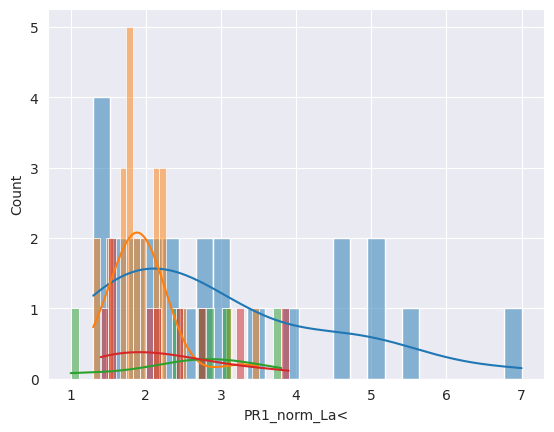

In [ ]:
sns.histplot(df_com.iloc[:,1], bins=25, kde=True)
sns.histplot(df_com.iloc[:,2], bins=25, kde=True)
sns.histplot(df_com.iloc[:,3], bins=25, kde=True)
sns.histplot(df_com.iloc[:,4], bins=25, kde=True)
plt.show()

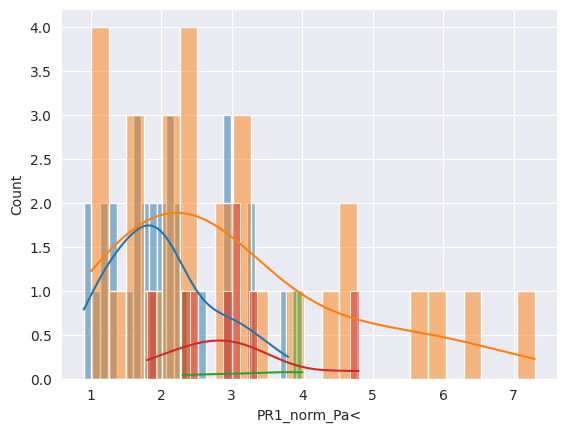

In [ ]:
sns.histplot(df_com.iloc[:,5], bins=25, kde=True)
sns.histplot(df_com.iloc[:,6], bins=25, kde=True)
sns.histplot(df_com.iloc[:,7], bins=25, kde=True)
sns.histplot(df_com.iloc[:,8], bins=25, kde=True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt # Подключаем модуль pyplot библиотеки matplotlib и задаем псевдоним plt
%matplotlib inline

plt.hist(x, bins=10, color='b', linewidth=10)

    x - переменная с массивом значений
    bins=10 - количество подгрупп, в которые объединятся данные
    color='b' - цвет гистограммы
    linewidth=10 - ширина столбцов гистограммы


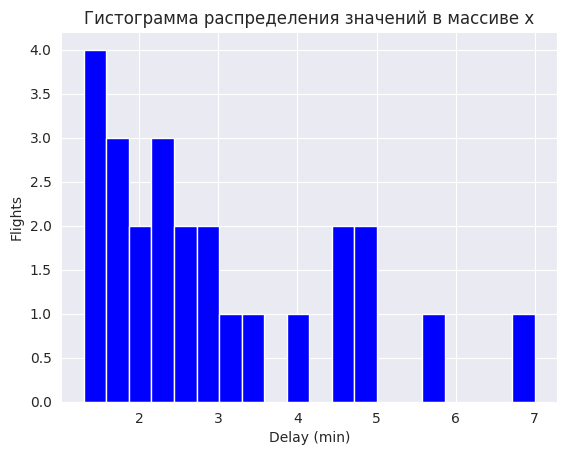

In [ ]:
plt.hist(coms_gist, bins=20, color='b', linewidth = 1) # параметр bins отвечает за количество подгрупп, в которые объединяются данные
plt.title('Гистограмма распределения значений в массиве х')
plt.xlabel('Delay (min)')
plt.ylabel('Flights')
plt.show()

===============================================================================================